In [17]:
import simpy 
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import math

In [2]:

import random
import simpy

waiting_times = []
service_times = []

def source(env, number, lambd, mu, counter, B_distribution, shortest_job_first=False):
    """Source generates customers randomly"""
    t0 = np.random.exponential(1/lambd) # Arrival time of first customer
    yield env.timeout(t0)

    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, mu, B_distribution, shortest_job_first)
        env.process(c)

        # A distribution
        t = np.random.exponential(1/lambd)
        yield env.timeout(t)
   
def customer(env, name, counter, mu, B_distribution, shortest_job_first=False):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    # print('%7.4f %s: Here I am' % (arrive, name))
    
    # B distribution
    service_time = B_distribution() # np.random.exponential(1/mu)
    # print(service_time)

    priority = service_time if shortest_job_first else 1

    with counter.request(priority=priority) as req: 
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        # print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        service_times.append(service_time)
        yield env.timeout(service_time)
        # print('%7.4f %s: Finished' % (env.now, name))


In [3]:

random.seed(RANDOM_SEED)

def mmc_sim(new_customers, lambd, mu, capacity, B_distribution, shortest_job_first=False):
    global waiting_times
    global service_times
    waiting_times = []
    service_times = []
    
    env = simpy.Environment()

    # Start processes and run
    counter = simpy.PriorityResource(env, capacity=capacity)
    env.process(source(env, new_customers, lambd, mu, counter, B_distribution, shortest_job_first))
    env.run()
    
    return waiting_times, service_times

In [4]:
def long_tail_distribution(avg_1, avg_2, chance_1):
    if np.random.rand() < chance_1:
        return np.random.exponential(scale=avg_1)
    else:
        return np.random.exponential(scale=avg_2)

In [6]:
# Start out with mu = 0.1, rho = 0.9

# Variation of simulation function where you input rho and the function calculates a lambda 
def queueing_simulations2(new_customers, rho, mu, capacity, n_samples, B_distribution, shortest_job_first = False):
    global waiting_times
    global service_times

    lambd = rho * capacity * mu 
    dict_wt = {}
    dict_st = {}

    for i in range(n_samples):
        print(i)
        waiting_times = []
        service_times = []
        waiting_times, service_times = mmc_sim(new_customers, lambd, mu, capacity, B_distribution, shortest_job_first)
        dict_wt[i] = waiting_times
        dict_st[i] = service_times

    return dict_wt, dict_st

In [7]:
def compute_lmeanwt(result_dict):
    l_mean_wt = []
    for key in result_dict.keys(): 
        l_mean_wt.append(np.mean(result_dict[key]))
    return l_mean_wt

In [8]:
def compute_meanwt(result_dict):
    l_mean_wt = []
    for key in result_dict.keys(): 
        l_mean_wt.append(np.mean(result_dict[key]))
    mean_wt = np.mean(l_mean_wt)
    return mean_wt

def compute_varwt(result_dict):
    l_mean_wt = []
    for key in result_dict.keys(): 
        l_mean_wt.append(np.mean(result_dict[key]))
    var_wt = np.var(l_mean_wt)
    return var_wt

print(compute_meanwt(result_n1[0]))
print(compute_varwt(result_n1[0]))
print(compute_meanwt(result_n2[0]))
print(compute_varwt(result_n2[0]))

NameError: name 'result_n1' is not defined

In [50]:
# Simulations question 2 for n = 1, n = 2, and n = 4
mu = 1

l_rho = np.linspace(0.01, 1, 20)

p_vals12 = []
p_vals14 = []
p_vals24 = []
p_vals11p = []
p_vals21p = []
p_vals41p = []
mean_waitsn1 = []
mean_waitsn2 = []
mean_waitsn4 = []
mean_waitsn1p = []
std_waitsn1 = []
std_waitsn2 = []
std_waitsn4 = []
std_waitsn1p = []

for rho in l_rho: 
    print(f'rho = {rho}')
    resultn1 = queueing_simulations2(1000, rho, 1, 1, 300, lambda: np.random.exponential(1/mu))
    resultn2 = queueing_simulations2(1000, rho, 1, 2, 300, lambda: np.random.exponential(1/mu))
    resultn4 = queueing_simulations2(1000, rho, 1, 4, 300, lambda: np.random.exponential(1/mu))
    resultn1p = queueing_simulations2(1000, rho, 1, 1, 300, lambda: np.random.exponential(1/mu), shortest_job_first = True)
    
    meanswt1 = compute_lmeanwt(resultn1[0])
    meanswt2 = compute_lmeanwt(resultn2[0])
    meanswt4 = compute_lmeanwt(resultn4[0])
    meanswt1p = compute_lmeanwt(resultn1p[0])

    mean_waitsn1.append(np.mean(meanswt1))
    mean_waitsn2.append(np.mean(meanswt2))
    mean_waitsn4.append(np.mean(meanswt4))
    mean_waitsn1p.append(np.mean(meanswt1p))

    std_waitsn1.append(np.std(meanswt1))
    std_waitsn2.append(np.std(meanswt2))
    std_waitsn4.append(np.std(meanswt4))
    std_waitsn1p.append(np.std(meanswt1p))


    p_vals12.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals14.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals24.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals11p.append(scipy.stats.ttest_ind(meanswt1, meanswt1p, equal_var = True)[1])
    p_vals21p.append(scipy.stats.ttest_ind(meanswt2, meanswt1p, equal_var = True)[1])
    p_vals41p.append(scipy.stats.ttest_ind(meanswt4, meanswt1p, equal_var = True)[1])


rho = 0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274

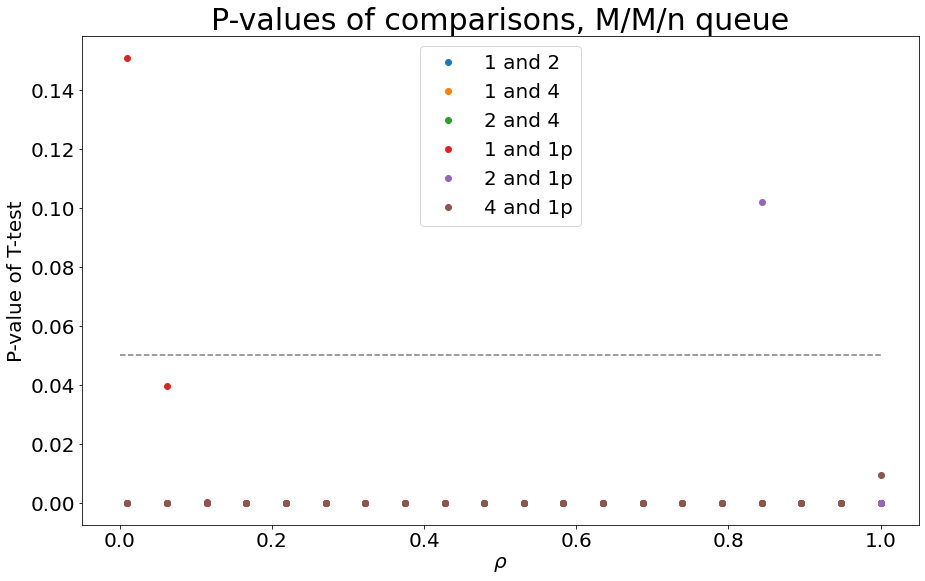

In [131]:

plt.figure(figsize = (15,9))
plt.plot(l_rho, p_vals12, 'o', label = '1 and 2')
plt.plot(l_rho, p_vals14, 'o', label = '1 and 4')
plt.plot(l_rho, p_vals12, 'o', label = '2 and 4')
plt.plot(l_rho, p_vals11p, 'o', label = '1 and 1p')
plt.plot(l_rho, p_vals21p, 'o', label = '2 and 1p')
plt.plot(l_rho, p_vals41p, 'o', label = '4 and 1p')

plt.hlines(0.05, xmin = 0, xmax = 1, color = 'grey', ls = 'dashed')

plt.xlabel(r'$\rho$', fontsize = 20)
plt.ylabel('P-value of T-test', fontsize = 20)
plt.title('P-values of comparisons, M/M/n queue', fontsize = 30)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('plots2/appendix1')
plt.show()

lower1 = [mean_waitsn1[i] - std_waitsn1[i] for i,val in enumerate(mean_waitsn1)]
upper1 = [mean_waitsn1[i] + std_waitsn1[i] for i,val in enumerate(mean_waitsn1)]

lower2 = [mean_waitsn2[i] - std_waitsn2[i] for i,val in enumerate(std_waitsn2)]
upper2 = [mean_waitsn2[i] + std_waitsn2[i] for i,val in enumerate(std_waitsn2)]

lower4 = [mean_waitsn4[i] - std_waitsn4[i] for i,val in enumerate(std_waitsn4)]
upper4 = [mean_waitsn4[i] + std_waitsn4[i] for i,val in enumerate(std_waitsn4)]

lower1p = [mean_waitsn1p[i] - std_waitsn1p[i] for i,val in enumerate(mean_waitsn1p)]
upper1p = [mean_waitsn1p[i] + std_waitsn1p[i] for i,val in enumerate(mean_waitsn1p)]


plt.figure(figsize = (15,9))
plt.plot(l_rho, mean_waitsn1, label = 'n = 1', marker = '.', color = 'tab:blue')
plt.plot(l_rho, mean_waitsn2, label = 'n = 2', marker = '.', color = 'tab:red')
plt.plot(l_rho, mean_waitsn4, label = 'n = 4', marker = '.', color = 'tab:green')
plt.plot(l_rho, mean_waitsn1p, label = 'n = 1, shortest job first', marker = '.', color = 'tab:cyan')


plt.fill_between(l_rho, lower1, upper1, color = 'tab:blue', alpha = 0.2)
plt.fill_between(l_rho, lower2, upper2, color = 'tab:red', alpha = 0.2)
plt.fill_between(l_rho, lower4, upper4, color = 'tab:green', alpha = 0.2)
plt.fill_between(l_rho, lower1p, upper1p, color = 'tab:cyan', alpha = 0.2)

plt.legend()
plt.show()


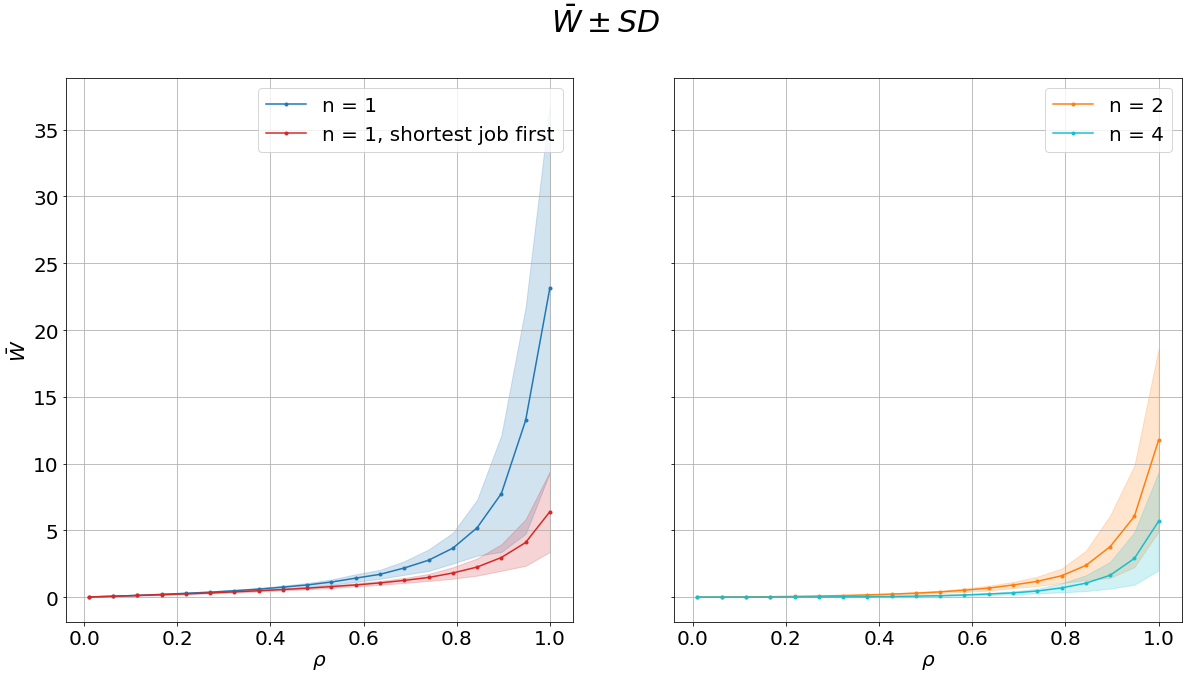

In [72]:

figs, axs = plt.subplots(1,2 , sharex = True, sharey = True, figsize = (20,10))

plt.suptitle(r'$\bar{W} \pm SD$', fontsize = 30)

axs[0].plot(l_rho, mean_waitsn1, label = 'n = 1', marker = '.', color = 'tab:blue')
axs[0].plot(l_rho, mean_waitsn1p, label = 'n = 1, shortest job first', marker = '.', color = 'tab:red')
axs[0].fill_between(l_rho, lower1, upper1, color = 'tab:blue', alpha = 0.2)
axs[0].fill_between(l_rho, lower1p, upper1p, color = 'tab:red', alpha = 0.2)
axs[0].legend(fontsize = 20)
axs[0].grid(True)
axs[0].tick_params(labelsize = 20)
axs[0].set_ylabel(r'$\bar{W}$', fontsize = 20)
axs[0].set_xlabel(r'$\rho$', fontsize = 20)

axs[1].plot(l_rho, mean_waitsn2, label = 'n = 2', marker = '.', color = 'tab:orange')
axs[1].plot(l_rho, mean_waitsn4, label = 'n = 4', marker = '.', color = 'tab:cyan')
axs[1].fill_between(l_rho, lower2, upper2, color = 'tab:orange', alpha = 0.2)
axs[1].fill_between(l_rho, lower4, upper4, color = 'tab:cyan', alpha = 0.2)
axs[1].tick_params(labelsize = 20)
axs[1].legend(fontsize = 20)
axs[1].grid(True)
axs[1].set_xlabel(r'$\rho$', fontsize = 20)

plt.savefig('plots2/fig2.pdf')
plt.show()






### Observations: 

- Wait times are lower for higher n
- Wait times of M/M/1 with priority are similar to n = 1 for lower rho, to n = 2 for higher rho. At least there is no significant difference. 
- Variance grows for higher rho
- 

In [93]:
# Question 4: M/M/D queue
# Simulations question 2 for n = 1, n = 2, and n = 4
mu = 1

l_rho = np.linspace(0.01, 1, 20)

p_vals12 = []
p_vals14 = []
p_vals24 = []
p_vals11p = []
p_vals21p = []
p_vals41p = []
mean_waitsn1 = []
mean_waitsn2 = []
mean_waitsn4 = []
mean_waitsn1p = []
std_waitsn1 = []
std_waitsn2 = []
std_waitsn4 = []
std_waitsn1p = []

for rho in l_rho: 
    print(f'rho = {rho}')
    resultn1 = queueing_simulations2(1000, rho, 1, 1, 300, lambda: 1)
    resultn2 = queueing_simulations2(1000, rho, 1, 2, 300, lambda: 1)
    resultn4 = queueing_simulations2(1000, rho, 1, 4, 300, lambda: 1)
    
    meanswt1 = compute_lmeanwt(resultn1[0])
    meanswt2 = compute_lmeanwt(resultn2[0])
    meanswt4 = compute_lmeanwt(resultn4[0])

    mean_waitsn1.append(np.mean(meanswt1))
    mean_waitsn2.append(np.mean(meanswt2))
    mean_waitsn4.append(np.mean(meanswt4))

    std_waitsn1.append(np.std(meanswt1))
    std_waitsn2.append(np.std(meanswt2))
    std_waitsn4.append(np.std(meanswt4))


    p_vals12.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals14.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals24.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    


rho = 0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274

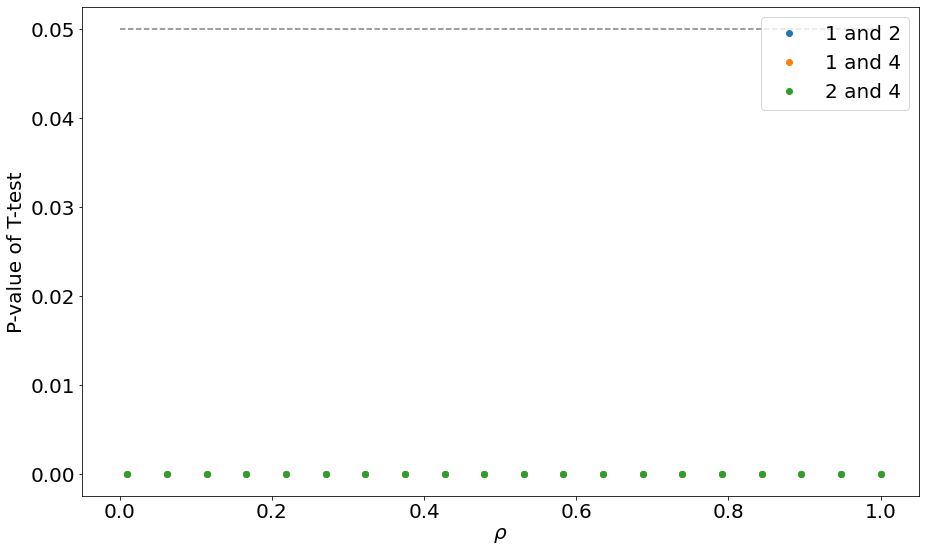

In [128]:



plt.figure(figsize = (15,9))
plt.plot(l_rho, p_vals12, 'o', label = '1 and 2')
plt.plot(l_rho, p_vals14, 'o', label = '1 and 4')
plt.plot(l_rho, p_vals12, 'o', label = '2 and 4')


plt.hlines(0.05, xmin = 0, xmax = 1, color = 'grey', ls = 'dashed')

plt.xlabel(r'$\rho$', fontsize = 20)
plt.ylabel('P-value of T-test', fontsize = 20)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('plots2/appendix2')
plt.show()

lower1 = [mean_waitsn1[i] - std_waitsn1[i] for i,val in enumerate(mean_waitsn1)]
upper1 = [mean_waitsn1[i] + std_waitsn1[i] for i,val in enumerate(mean_waitsn1)]

lower2 = [mean_waitsn2[i] - std_waitsn2[i] for i,val in enumerate(std_waitsn2)]
upper2 = [mean_waitsn2[i] + std_waitsn2[i] for i,val in enumerate(std_waitsn2)]

lower4 = [mean_waitsn4[i] - std_waitsn4[i] for i,val in enumerate(std_waitsn4)]
upper4 = [mean_waitsn4[i] + std_waitsn4[i] for i,val in enumerate(std_waitsn4)]



plt.figure(figsize = (15,9))
plt.plot(l_rho, mean_waitsn1, label = 'n = 1', marker = '.', color = 'tab:blue')
plt.plot(l_rho, mean_waitsn2, label = 'n = 2', marker = '.', color = 'tab:red')
plt.plot(l_rho, mean_waitsn4, label = 'n = 4', marker = '.', color = 'tab:green')


plt.fill_between(l_rho, lower1, upper1, color = 'tab:blue', alpha = 0.2)
plt.fill_between(l_rho, lower2, upper2, color = 'tab:red', alpha = 0.2)
plt.fill_between(l_rho, lower4, upper4, color = 'tab:green', alpha = 0.2)


plt.yticks(np.arange(0, 40, 5), fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel(r'$\bar{W}$', fontsize = 20)
plt.xlabel(r'$\rho$', fontsize = 20)
plt.title(r'$\bar{W} \pm SD$', fontsize = 30)
plt.grid(True)

plt.legend(fontsize = 20)
plt.savefig('plots2/fig3.pdf')
plt.show()

In [116]:
# Question 4: Long tailed distribution

# Simulations question 2 for n = 1, n = 2, and n = 4
mu = 1

l_rho = np.linspace(0.01, 1, 20)

p_vals12 = []
p_vals14 = []
p_vals24 = []
p_vals11p = []
p_vals21p = []
p_vals41p = []
mean_waitsn1 = []
mean_waitsn2 = []
mean_waitsn4 = []
mean_waitsn1p = []
std_waitsn1 = []
std_waitsn2 = []
std_waitsn4 = []
std_waitsn1p = []

for rho in l_rho: 
    print(f'rho = {rho}')
    resultn1 = queueing_simulations2(1000, rho, 1, 1, 300, lambda: long_tail_distribution(1, 5, 0.75))
    resultn2 = queueing_simulations2(1000, rho, 1, 2, 300, lambda: long_tail_distribution(1, 5, 0.75))
    resultn4 = queueing_simulations2(1000, rho, 1, 4, 300, lambda: long_tail_distribution(1, 5, 0.75))
    resultn1p = queueing_simulations2(1000, rho, 1, 1, 300, lambda: long_tail_distribution(1, 5, 0.75), shortest_job_first = True)
    
    meanswt1 = compute_lmeanwt(resultn1[0])
    meanswt2 = compute_lmeanwt(resultn2[0])
    meanswt4 = compute_lmeanwt(resultn4[0])
    meanswt1p = compute_lmeanwt(resultn1p[0])

    mean_waitsn1.append(np.mean(meanswt1))
    mean_waitsn2.append(np.mean(meanswt2))
    mean_waitsn4.append(np.mean(meanswt4))
    mean_waitsn1p.append(np.mean(meanswt1p))

    std_waitsn1.append(np.std(meanswt1))
    std_waitsn2.append(np.std(meanswt2))
    std_waitsn4.append(np.std(meanswt4))
    std_waitsn1p.append(np.std(meanswt1p))


    p_vals12.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals14.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals24.append(scipy.stats.ttest_ind(meanswt1, meanswt2, equal_var = True)[1])
    p_vals11p.append(scipy.stats.ttest_ind(meanswt1, meanswt1p, equal_var = True)[1])
    p_vals21p.append(scipy.stats.ttest_ind(meanswt2, meanswt1p, equal_var = True)[1])
    p_vals41p.append(scipy.stats.ttest_ind(meanswt4, meanswt1p, equal_var = True)[1])


rho = 0.01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274

In [ ]:


plt.figure(figsize = (15,9))
plt.plot(l_rho, p_vals12, 'o', label = '1 and 2')
plt.plot(l_rho, p_vals14, 'o', label = '1 and 4')
plt.plot(l_rho, p_vals12, 'o', label = '2 and 4')
plt.plot(l_rho, p_vals11p, 'o', label = '1 and 1p')
plt.plot(l_rho, p_vals21p, 'o', label = '2 and 1p')
plt.plot(l_rho, p_vals41p, 'o', label = '4 and 1p')


plt.hlines(0.05, xmin = 0, xmax = 1, color = 'grey', ls = 'dashed')

plt.xlabel(r'$\rho$', fontsize = 20)
plt.ylabel('P-value of T-test', fontsize = 20)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('plots2/appendix3')
plt.show()

lower1 = [mean_waitsn1[i] - std_waitsn1[i] for i,val in enumerate(mean_waitsn1)]
upper1 = [mean_waitsn1[i] + std_waitsn1[i] for i,val in enumerate(mean_waitsn1)]

lower2 = [mean_waitsn2[i] - std_waitsn2[i] for i,val in enumerate(std_waitsn2)]
upper2 = [mean_waitsn2[i] + std_waitsn2[i] for i,val in enumerate(std_waitsn2)]

lower4 = [mean_waitsn4[i] - std_waitsn4[i] for i,val in enumerate(std_waitsn4)]
upper4 = [mean_waitsn4[i] + std_waitsn4[i] for i,val in enumerate(std_waitsn4)]

lower1p = [mean_waitsn1p[i] - std_waitsn1p[i] for i,val in enumerate(mean_waitsn1p)]
upper1p = [mean_waitsn1p[i] + std_waitsn1p[i] for i,val in enumerate(mean_waitsn1p)]


plt.figure(figsize = (15,9))
plt.plot(l_rho, mean_waitsn1, label = 'n = 1', marker = '.', color = 'tab:blue')
plt.plot(l_rho, mean_waitsn2, label = 'n = 2', marker = '.', color = 'tab:red')
plt.plot(l_rho, mean_waitsn4, label = 'n = 4', marker = '.', color = 'tab:green')
plt.plot(l_rho, mean_waitsn1p, label = 'n = 1, shortest job first', marker = '.', color = 'tab:cyan')


plt.fill_between(l_rho, lower1, upper1, color = 'tab:blue', alpha = 0.2)
plt.fill_between(l_rho, lower2, upper2, color = 'tab:red', alpha = 0.2)
plt.fill_between(l_rho, lower4, upper4, color = 'tab:green', alpha = 0.2)
plt.fill_between(l_rho, lower1p, upper1p, color = 'tab:cyan', alpha = 0.2)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel(r'$\bar{W}$', fontsize = 20)
plt.xlabel(r'$\rho$', fontsize = 20)
plt.title(r'$\bar{W} \pm SD$', fontsize = 30)
plt.grid(True)

plt.legend(fontsize = 20)
plt.savefig('plots2/fig4.pdf')

plt.show()

In [19]:
def theoretical_mwt(labda, mu, capacity):
    rho = labda/(capacity*mu)

    p_0_inverse = 0
    for n in range(capacity):
        p_0_inverse += (capacity*rho)**n/math.factorial(n) + ((capacity*rho)**capacity/math.factorial(capacity))/(1-rho)

    p_0 = 1/p_0_inverse
    p_c = (capacity*rho)**capacity/math.factorial(capacity) * p_0
    delay_probability = p_c/(1-rho)
    E_W = delay_probability * (1/(1-rho)) * 1/(capacity*mu)

    return E_W

def theoretical_mwt_c1(rho, mu): 
    return (rho/mu)/(1-rho)



In [41]:
# Find out how many customers are needed to get significantly close to the theoretical mean, alpha = 0.05

# Function to find the number of customers for which the empirical mean is statistically no different from the theoretical

def queueing_simulations3(new_customers, rho, mu, capacity, n_samples):

    lambd = rho * capacity * mu
    l_wt = []
    l_st = []

    for i in range(n_samples):
        global waiting_times
        global service_times
        waiting_times = []
        service_times = []
        waiting_times, service_times = mmc_sim(new_customers, lambd, mu, capacity, np.random.exponential)

        l_wt.append(np.mean(waiting_times))
        l_st.append(np.mean(service_times))

    return l_wt, l_st

def evaluate_n_customers(rho, mu, capacity, n_samples, alpha, step_size): 
    lambd = rho * capacity * mu
    if capacity == 1: 
        E_wt = theoretical_mwt_c1(rho, mu)
    E_wt = theoretical_mwt(rho, mu, capacity)

    n_customer = 1
    l_ncustomers = []
    l_pvals = []

    l_mean_wt = queueing_simulations3(n_customer, rho, mu, capacity, n_samples)[0]
    p_val = scipy.stats.ttest_1samp(l_mean_wt, E_wt)[1]
    l_pvals.append(p_val)
    l_ncustomers.append(n_customer)
    n_customer += (step_size - 1)

    while l_pvals[-1] < alpha: 
        l_mean_wt = queueing_simulations3(n_customer, rho, mu, capacity, n_samples)[0]

        p_val = scipy.stats.ttest_1samp(l_mean_wt, E_wt)[1]

        l_pvals.append(p_val)
        l_ncustomers.append(n_customer)

        if n_customer % (5*step_size) == 0: 
            print(n_customer)
        n_customer += step_size

    return l_pvals, l_ncustomers
    


5
([0.0, 0.0, 5.150930557420171e-12, 0.0006719780988094383, 0.0493782196798502, 0.28036083686459023], [1, 1, 2, 3, 4, 5])


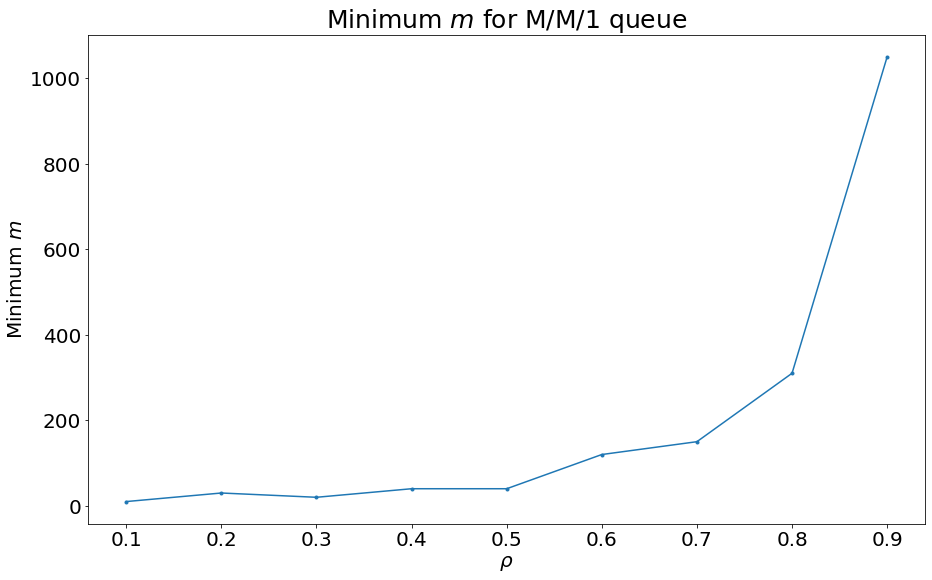

In [89]:
l_rho = np.arange(0.1, 1, 0.1)

list1 = []
list2 = []

for rho in l_rho: 
    result = evaluate_n_customers(rho, 1, 1, 200, 0.05, 10)
    list1.append(result[0][-1])
    list2.append(result[1][-1])
    print(f'rho = {rho}')

plt.figure(figsize = (15,9))
plt.plot(l_rho[:-1], list2[:-1], color = 'tab:blue', marker = '.')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel(r'$\rho$', fontsize = 20)
plt.ylabel(r'Minimum $m$', fontsize = 20)
plt.title(r'Minimum $m$ for M/M/1 queue', fontsize = 25)


plt.savefig('plots2/fig1.pdf')
plt.show()